In [1]:
#同时包括常用的一些库
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import gzip
from IPython import display

import pandas as pd
import seaborn as sns
import math
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def get_data():
    # 文件获取
    train_image = r"C:/Users/TZH/Desktop/flow_code/train-images-idx3-ubyte.gz"
    test_image = r"C:/Users/TZH/Desktop/flow_code/t10k-images-idx3-ubyte.gz"
    train_label = r"C:/Users/TZH/Desktop/flow_code/train-labels-idx1-ubyte.gz"
    test_label = r"C:/Users/TZH/Desktop/flow_code/t10k-labels-idx1-ubyte.gz" #文件路径
    paths = [train_label, train_image, test_label,test_image]

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

    return (x_train, y_train), (x_test, y_test)


In [3]:
#加载MNIST数据集

(train_images, _), (test_images, _) = get_data()
#tf.keras.datasets.mnist.load_data的含义是导入mnist数据集
#(train_images, _), (test_images, _)是将数据集分割为训练集和测试集
#其中，调用的方法是，括号中第一项表示数据，第二项表示标签；这里用下划线表示标签变量不需要使用

#得到是60000*28*28*1的数据，其中60000表示数据个数，28*28是图像的空间大小

In [4]:
#这里首先进行的操作是将三阶张量转化为四阶张量，便于后续batch的计算

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#这里train_images.shape[0]表示三元数组（60000，28，28）中的第一元，数值为60000；
#该操作将第一行转化为一列，第二行转化为第二列同时拼接在第一列下方，以此类推
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

#变形后的数据为4阶张量（60000，28，28，1）


#每个 MNIST 图片最初都是包含 784 个整数的向量（28*28）将矩阵拉为一个向量
#每个整数取值都在 0-255 之间，表示像素的强度。
#我们在模型中使用伯努利分布对每个像素进行建模，并对数据集进行静态二值化。
# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# 二值化（以0.5为分界点，将图像进行0、1的修订）
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [5]:
#设定参数，以及Minibatch的个数
TRAIN_BUF = 60000   #训练数据集混乱程度
BATCH_SIZE = 100    #单位批量处理数据的大小
TEST_BUF = 10000    #测试数据集混乱程度

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [7]:
def dense_layers(in_units, out_units, hidden_layers=[128, 128]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(in_units,)))
    for i in hidden_layers:
        model.add(tf.keras.layers.Dense(i))
    model.add(tf.keras.layers.Dense(out_units))
    return model

In [8]:
#定义条件分布的神经网络
class RealNVPF(tf.keras.models.Model):
    def __init__(self, in_units, out_units, cond_units, hidden_layers=[128, 128]):
        super().__init__()
        self.shift = dense_layers(in_units + cond_units, out_units, hidden_layers)
        self.log_scale = dense_layers(in_units + cond_units, out_units, hidden_layers)
        self.cvar = None
    
    def set_condvar(self, x):
        self.cvar = x

    def call(self, *inputs):
        #print(self.cvar.shape)
        #print(inputs[0].shape)
        inputs = tf.concat([inputs[0], self.cvar], axis=1)
        shift = self.shift(inputs)
        scale = tf.sigmoid(self.log_scale(inputs))*2 + 0.1
        log_scale = tf.math.log(scale)
        return shift, log_scale

In [9]:
#通过 tf.keras.Sequential 连接生成网络与推理网络

#开始建立网络模型CNN-VAE
class Cond_VAE(tf.keras.Model):
    
    #在这种方法中，我们需要定义自己的__init__并且在call方法中实现网络的前向传播结构(即在这个方法中定义网络结构)。
    def __init__(self, latent_dim, cond_dim, flow_depth=3, flow_hidden=[128, 128]):
        super(Cond_VAE, self).__init__()
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.flow_depth = flow_depth

        

        self.inference_net = tf.keras.Sequential(          
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),                 
          
          
                tf.keras.layers.Conv2D(
                    filters=32, 
                    kernel_size=3, 
                    strides=(2, 2), 
                    activation = tf.nn.relu),    
  
                tf.keras.layers.Conv2D(
                    filters=64, 
                    kernel_size=3, 
                    strides=(2, 2), 
                    activation = tf.nn.relu),

          
                tf.keras.layers.Flatten(),

          
    
                tf.keras.layers.Dense( latent_dim + latent_dim + cond_dim ),

            ]
         )

    
        #生成网络的设置
        self.generative_net = tf.keras.Sequential(
            [
            
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),

                tf.keras.layers.Dense(units=7*7*32, activation = tf.nn.relu),

            
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),


                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation='relu'),     
            
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation='relu'),    
          
                tf.keras.layers.Conv2DTranspose(
                    filters=1, 
                    kernel_size=3, 
                    strides=(1, 1), 
                    padding="SAME"),
        ]
    )
      
        self.realnvp = []
        data_in_dim = latent_dim // 2  
        data_out_dim = latent_dim - data_in_dim
        
        for _ in range(flow_depth):
            self.realnvp.append(
                RealNVPF(data_in_dim, data_out_dim, cond_dim, flow_hidden)
            )
            
        f = tfb.Identity()
        
        
        for i in range(flow_depth):
            perm = np.random.permutation(latent_dim)
            f = tfb.Permute(perm)(f)
            f = tfb.RealNVP(data_in_dim, shift_and_log_scale_fn=self.realnvp[i])(f)

        self.bijector = f
        
        
    @tf.function    
    def sample(self, eps=None): 
    # 采样
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))     
        return  self.decode(eps, apply_sigmoid=False)

   
    def encode(self, x):
    # 编码器
        mean, logvar, cond = tf.split(self.inference_net(x), num_or_size_splits=[latent_dim, latent_dim, cond_dim], axis=1)

        return mean, logvar, cond


    def sample_posterior(self, mean, logvar, cond):
        for i in range(self.flow_depth):
            self.realnvp[i].set_condvar(cond)
        dist_ = tfp.distributions.MultivariateNormalDiag(
            loc=mean, scale_diag=tf.math.exp(0.5 * logvar)
        )

        dist = tfd.TransformedDistribution(
            distribution=dist_,
            bijector=self.bijector
        )
        return dist, dist.sample()


    
    def decode(self, z, apply_sigmoid=False):
    # 解码器   
        logits = self.generative_net(z)
        logits = tf.clip_by_value(logits,-10,10)
        if apply_sigmoid:
            logits = tf.sigmoid(logits) 
            return logits
        return logits


In [10]:
  optimizer = tf.keras.optimizers.Adam(1e-3)

In [11]:
def KL_Divergence(dist, z):
    
    k = z.shape[1]
    
    
    logpz = - 0.5 * tf.reduce_mean(tf.reduce_sum(tf.pow(z,2), axis=1  )) - 0.5 * k * math.log(2.0 * math.pi)
    
    logqzx = tf.reduce_mean(dist.log_prob(z))
    
    return logqzx - logpz


def Likelihood_Loss(x, zdec):

    log_p = tf.math.log_sigmoid(zdec)
    #log(1-p) = -zdec + log_p
    log_1_p = -zdec + log_p
    loglik_loss =  tf.reduce_sum(x*log_p + (1.0 - x)*log_1_p , axis = [1,2,3])

    return tf.reduce_mean(loglik_loss)
  



def compute_loss(model, x):
    mean, logvar, cond = model.encode(x)
    #首先得到均值、方差
    
    #x_reshape = tf.reshape(x,[100,784])

    dist, z = model.sample_posterior(mean, logvar, cond)
    #其次，以此为基础，使用flow进行近似
    
    z_dec = model.decode(z, apply_sigmoid=False)
    #得到的隐变量再次进行网络计算
    
    KL_loss = KL_Divergence(dist, z)
    Log_loss = Likelihood_Loss(x, z_dec)
    return Log_loss, KL_loss

In [12]:
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss_log, loss_KL = compute_loss(model, x)
        loss = -(loss_log - loss_KL)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss.numpy(), -loss_log.numpy(), loss_KL.numpy()

In [13]:
epochs = 50
latent_dim = 15
cond_dim = 784
#隐变量维数，20维
num_examples_to_generate = 16
#保持随机向量恒定以进行生成（预测），以便更易于看到改进。
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = Cond_VAE(latent_dim,cond_dim, flow_depth=5, flow_hidden=[64, 64])

In [14]:
#定义一个生成器
def generate_and_save_images(model, epoch, test_input):
    #输入的参数包含模型、迭代次数、以及测试图片
    predictions = model.sample(test_input)
    predictions = tf.reshape(predictions,[16,28,28,1])
    fig = plt.figure(figsize=(4,4))
    print(predictions.shape)
    #生成4*4幅图片
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show() 

(16, 28, 28, 1)


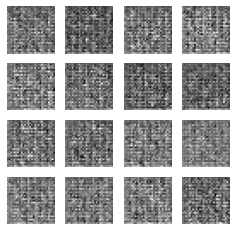

In [15]:
#首次循环，得到初始值
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 28, Test set ELBO: 37.605098724365234, time elapse for current epoch 327.4809410572052
(16, 28, 28, 1)


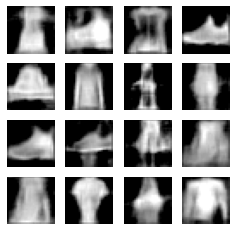

epoch = 29, batch = 0, lossval = 119.83222198486328, loss_log = 96.17139434814453, loss_kl = 23.66082763671875
epoch = 29, batch = 1, lossval = 115.23695373535156, loss_log = 92.07115173339844, loss_kl = 23.165800094604492
epoch = 29, batch = 2, lossval = 118.85623168945312, loss_log = 94.847412109375, loss_kl = 24.008817672729492
epoch = 29, batch = 3, lossval = 113.88284301757812, loss_log = 90.96021270751953, loss_kl = 22.922630310058594
epoch = 29, batch = 4, lossval = 114.560546875, loss_log = 91.54495239257812, loss_kl = 23.015592575073242
epoch = 29, batch = 5, lossval = 123.15739440917969, loss_log = 99.55040740966797, loss_kl = 23.606990814208984
epoch = 29, batch = 6, lossval = 114.20258331298828, loss_log = 90.93372344970703, loss_kl = 23.26885986328125
epoch = 29, batch = 7, lossval = 118.82921600341797, loss_log = 95.19812774658203, loss_kl = 23.631086349487305
epoch = 29, batch = 8, lossval = 124.88783264160156, loss_log = 101.8586196899414, loss_kl = 23.029212951660156
e

epoch = 29, batch = 74, lossval = 113.4493408203125, loss_log = 90.52212524414062, loss_kl = 22.927213668823242
epoch = 29, batch = 75, lossval = 124.14657592773438, loss_log = 100.837158203125, loss_kl = 23.30942153930664
epoch = 29, batch = 76, lossval = 108.51994323730469, loss_log = 85.71011352539062, loss_kl = 22.809829711914062
epoch = 29, batch = 77, lossval = 115.21733856201172, loss_log = 91.974609375, loss_kl = 23.24272918701172
epoch = 29, batch = 78, lossval = 118.12921142578125, loss_log = 94.20524597167969, loss_kl = 23.923961639404297
epoch = 29, batch = 79, lossval = 113.13636016845703, loss_log = 89.48303985595703, loss_kl = 23.653322219848633
epoch = 29, batch = 80, lossval = 125.06350708007812, loss_log = 100.9650650024414, loss_kl = 24.09844398498535
epoch = 29, batch = 81, lossval = 122.52404022216797, loss_log = 98.68869018554688, loss_kl = 23.83534812927246
epoch = 29, batch = 82, lossval = 107.1661148071289, loss_log = 84.06944274902344, loss_kl = 23.09667205810

epoch = 29, batch = 147, lossval = 118.57560729980469, loss_log = 94.53311157226562, loss_kl = 24.042491912841797
epoch = 29, batch = 148, lossval = 116.64462280273438, loss_log = 92.88280487060547, loss_kl = 23.761821746826172
epoch = 29, batch = 149, lossval = 113.2119140625, loss_log = 90.06117248535156, loss_kl = 23.150745391845703
epoch = 29, batch = 150, lossval = 123.67023468017578, loss_log = 100.52433776855469, loss_kl = 23.145896911621094
epoch = 29, batch = 151, lossval = 127.48617553710938, loss_log = 104.01960754394531, loss_kl = 23.466569900512695
epoch = 29, batch = 152, lossval = 128.7103729248047, loss_log = 105.03275299072266, loss_kl = 23.67761993408203
epoch = 29, batch = 153, lossval = 127.33576202392578, loss_log = 103.77679443359375, loss_kl = 23.558969497680664
epoch = 29, batch = 154, lossval = 104.89088439941406, loss_log = 82.05419158935547, loss_kl = 22.836688995361328
epoch = 29, batch = 155, lossval = 115.934326171875, loss_log = 92.97650146484375, loss_kl

epoch = 29, batch = 220, lossval = 103.60273742675781, loss_log = 80.11304473876953, loss_kl = 23.489688873291016
epoch = 29, batch = 221, lossval = 114.38528442382812, loss_log = 90.66151428222656, loss_kl = 23.723770141601562
epoch = 29, batch = 222, lossval = 123.14533233642578, loss_log = 99.00350952148438, loss_kl = 24.141820907592773
epoch = 29, batch = 223, lossval = 107.33575439453125, loss_log = 84.43594360351562, loss_kl = 22.899810791015625
epoch = 29, batch = 224, lossval = 116.51625061035156, loss_log = 93.04673767089844, loss_kl = 23.46951675415039
epoch = 29, batch = 225, lossval = 112.16490936279297, loss_log = 88.98979187011719, loss_kl = 23.17511558532715
epoch = 29, batch = 226, lossval = 107.32839965820312, loss_log = 84.0102310180664, loss_kl = 23.31816864013672
epoch = 29, batch = 227, lossval = 110.33961486816406, loss_log = 86.75064086914062, loss_kl = 23.588977813720703
epoch = 29, batch = 228, lossval = 124.47277069091797, loss_log = 101.67448425292969, loss_k

epoch = 29, batch = 293, lossval = 126.35812377929688, loss_log = 101.59241485595703, loss_kl = 24.76570701599121
epoch = 29, batch = 294, lossval = 119.39229583740234, loss_log = 94.99239349365234, loss_kl = 24.399900436401367
epoch = 29, batch = 295, lossval = 117.24678039550781, loss_log = 93.69412994384766, loss_kl = 23.55264663696289
epoch = 29, batch = 296, lossval = 123.86972045898438, loss_log = 99.98234558105469, loss_kl = 23.887372970581055
epoch = 29, batch = 297, lossval = 108.14427947998047, loss_log = 84.87342071533203, loss_kl = 23.270858764648438
epoch = 29, batch = 298, lossval = 116.27616119384766, loss_log = 92.41166687011719, loss_kl = 23.86449432373047
epoch = 29, batch = 299, lossval = 124.03349304199219, loss_log = 100.39935302734375, loss_kl = 23.634136199951172
epoch = 29, batch = 300, lossval = 113.81185150146484, loss_log = 90.60903930664062, loss_kl = 23.20281410217285
epoch = 29, batch = 301, lossval = 120.0322265625, loss_log = 96.58534240722656, loss_kl =

In [ ]:
#开始循环计时，以及获取每次的ELBO
for epoch in range(1, epochs + 1):
  start_time = time.time()
  #设置起始时间
  for batch, train_x in enumerate(train_dataset):
  #这里开始对训练集进行循环，顺序是以train_x为变量，一个batch为一个数据，遍历整个train_dataset
  #基于mnist数据，将60000个样本每100个为一组，因此这里有600个train_x，循环600次
    lossval, loss_log, loss_kl = compute_apply_gradients(model, train_x, optimizer)
    #每次循环需要做的是计算梯度值，同时作记录，采用优化器优化
    print(f"epoch = {epoch}, batch = {batch}, lossval = {lossval}, loss_log = {loss_log}, loss_kl = {loss_kl}")
  end_time = time.time()
  #计时器的间隔为数据计算结束的时间点
  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    #这里开始计算模型的损失函数，先生成一个实例,之后将每次得到的值保存在loss中
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
      #循环计算损失值,并且保存在Loss的操作（目的是为了计录每个Batch的ELBO值）
    elbo = -loss.result()
    #计算得到elbo的平均值（本质上是把每次Batch得到的ELBO进行求和平均）
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(model, epoch, random_vector_for_generation)
    #保存图片